# Data Analysis for the Chinook Record Store

[Chinook](https://github.com/lerocha/chinook-database) is a sample database available for SQL Server, Oracle, MySQL, etc. It can be created by running a single SQL script. The Chinook data model represents a digital media store, including tables for artists, albums, media tracks, invoices and customers.

## Contents
- Helper Functions
- Database Schema
- Selecting Albums to Purchase
- Analyzing Employee Sales Performance
- Analyzing Sales by Country
- Summary & Additonal Questions

Here we act in the role of a data analyst tasked with answering business questions for the "Chinook Record Store" using SQL and standard python packages such as Pandas and Matplotlib. As such, we will go ahead and import our needed packages:

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Helper Functions

Here we define some helper functions to save some time. We are using a context manager to handle the connection to the SQLite database:

In [2]:
def run_query(q):
    # Takes a SQL query as an argument and returns a pandas dataframe of that query.
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [3]:
def run_command(c):
    """ Takes a SQL command as an argument and executes it using the sqlite module. 
    For SQL queries that don't return tables, like CREATE VIEW. 
    
    """
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [4]:
def show_tables():
    """ Calls the run_query() function to return a list of all tables and views in the database.
    Handy to quickly check the state of our database as we work.
    """
    q = ('SELECT name, type FROM sqlite_master WHERE type IN ("table","view");')
    return run_query(q)

In [5]:
# show_tables()

## Database Schema

<div>
<img src="chinook_schema.png" width="600"/>
</div>

## Selecting Albums to Purchase

The Chinook record store has just signed a deal with a new record label, and we've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

| Artist Name          | Genre   |
| -------------------- |:-------:|
| Regal                | Hip-Hop |
| Red Tone             | Punk    |
| Meteor and the Girls | Pop     |
| Slim Jim Bites       | Blues   |

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

We will query the Chinook database to find out which genres sell the most tracks in the USA. 

In [6]:
# Query to find out which genres sell the most tracks in the USA:
q = ("""     
            SELECT
                g.name genre,
                SUM(il.quantity) total_sales
            FROM genre g
            INNER JOIN track t ON t.genre_id = g.genre_id
            INNER JOIN invoice_line il ON il.track_id = t.track_id
            INNER JOIN invoice i ON i.invoice_id = il.invoice_id
            WHERE i.billing_country == 'USA'
            GROUP BY genre
            ORDER BY total_sales DESC;
            
           """)
run_query(q)

,genre,total_sales
0,Rock,561
1,Alternative & Punk,130
2,Metal,124
3,R&B/Soul,53
4,Blues,36
5,Alternative,35
6,Latin,22
7,Pop,22
8,Hip Hop/Rap,20
9,Jazz,14


In [7]:
# Assigning the query result (pandas dataframe) to a variable, then resetting the index to 'genre' for ease of use
absolute_sales = run_query(q)
absolute_sales = absolute_sales.set_index('genre')
absolute_sales

,total_sales
genre,
Rock,561
Alternative & Punk,130
Metal,124
R&B/Soul,53
Blues,36
Alternative,35
Latin,22
Pop,22
Hip Hop/Rap,20


In [8]:
#Filtering the dataframe by only the 4 genres that we wish to compare
absolute_sales = absolute_sales.filter(['Hip Hop/Rap', 'Alternative & Punk', 'Pop', 'Blues'], axis = 0)

In [9]:
#Determing the number of tracks sold in percentages - labeled as "market_share"
absolute_sales['market_share'] = absolute_sales['total_sales'] / sum(absolute_sales['total_sales'])

#Sorting the values by sales
absolute_sales = absolute_sales.sort_values(by = 'total_sales', ascending =False)

absolute_sales

,total_sales,market_share
genre,,
Alternative & Punk,130,0.625000
Blues,36,0.173077
Pop,22,0.105769
Hip Hop/Rap,20,0.096154


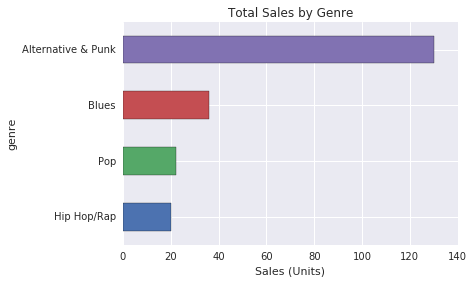

In [10]:
absolute_sales['total_sales'].sort_values().plot(kind = 'barh', title = 'Total Sales by Genre')
plt.xlabel('Sales (Units)')
plt.show()

Sorting and viewing the data in this way, we can see the top three genres (of our selected 4).
- Alternative & Punk is the clear winner, so the artist Red Tone should be a good choice for our customers. 
- Blues is the next contender (by a far margin from Punk), so Slim Jim Bites is the 2nd choice.

Pop and Rap and close in sales, though Pop had a couple more. The simple choice of artist would be Meteor and the Girls, but maybe an argument could be made for shifting trends in the musical landscape? An analysis of total sales by genre over several years could help reveal a trend.

Note: Date of sale was not taken into account in this analysis; the Chinook database data is over a four year period.

## Analyzing Employee Sales Performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. We will analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

We will query a table that finds the total dollar amount of sales assigned to each sales support agent within the company:

In [11]:
q = ("""     
            SELECT
               e.first_name || " " || e.last_name employee_name,
               e.hire_date,
               SUM(i.total) total_sales 
            FROM employee e
            INNER JOIN customer c ON c.support_rep_id = e.employee_id
            INNER JOIN invoice i ON i.customer_id = c.customer_id
            GROUP BY employee_name;
            
           """)
run_query(q)

,employee_name,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


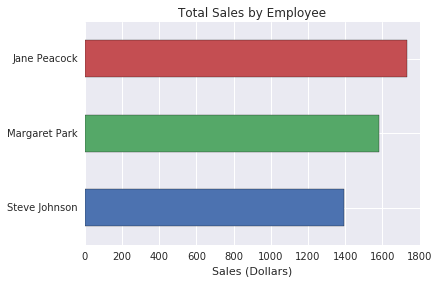

In [12]:
employee_total_sales = run_query(q)
employee_total_sales = employee_total_sales.set_index('employee_name')
employee_total_sales['total_sales'].sort_values().plot(kind = 'barh', title = 'Total Sales by Employee')
plt.xlabel('Sales (Dollars)')
plt.ylabel('')
plt.show()

Here we can clearly see the differences in sales between the 3 employees at Chinook store. The difference in sales correlate with the difference in their hire dates.

## Analyzing Sales by Country

Here we analyze the sales data for customers from each different country to determine which countries have potential for growth. We have been given guidance to use the country value from the customers table, and ignore the country from the billing address in the invoice table.

In particular, we have been directed to calculate data, for each country, on the:

- total number of customers
- total value of sales
- average value of sales per customer
- average order value

Note: Because there are a number of countries with only one customer, these customers will be grouped as "Other" in the analysis.

In [13]:
# Create view with countries having single customer grouped as Other
c = "DROP VIEW IF EXISTS country_or_other;"
run_command(c)

c = ("""    CREATE VIEW country_or_other AS 
                SELECT
                   CASE
                       WHEN(
                            SELECT count(*)
                            FROM customer
                            WHERE country = c.country
                            ) = 1 THEN "Other"
                        ELSE c.country
                    END AS country,
                    c.customer_id,
                    il.*
                FROM invoice_line il
                INNER JOIN invoice i ON i.invoice_id = il.invoice_id
                INNER JOIN customer c ON c.customer_id = i.customer_id;

            
            
           """)
run_command(c)

q = "Select * FROM country_or_other LIMIT 5;"
run_query(q)

,country,customer_id,invoice_line_id,invoice_id,track_id,unit_price,quantity
0,USA,18,1,1,1158,0.99,1
1,USA,18,2,1,1159,0.99,1
2,USA,18,3,1,1160,0.99,1
3,USA,18,4,1,1161,0.99,1
4,USA,18,5,1,1162,0.99,1


In [14]:
# Run query calculating data on purchases from different countries
q = ("""WITH sales_by_country AS   
            (
            SELECT
                country,
                COUNT(DISTINCT customer_id) customers,
                SUM(unit_price) total_sales,
                SUM(unit_price) / count(DISTINCT customer_id) average_total_per_customer,
                SUM(unit_price) / count(DISTINCT invoice_id) average_order,
                CASE
                    WHEN country = "Other" THEN 1
                    ELSE 0
                END AS sort
            FROM country_or_other
            GROUP BY country
            ORDER BY sort ASC, total_sales DESC
            )
        
        SELECT
            country,
            customers,
            total_sales,
            average_total_per_customer,
            average_order
        FROM sales_by_country                        
           """)

run_query(q)

,country,customers,total_sales,average_total_per_customer,average_order
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


In [15]:
sales_by_country = run_query(q)
sales_by_country = sales_by_country.set_index('country').round(2) # Setting the index and rounding to 2 decimal places
sales_by_country

,customers,total_sales,average_total_per_customer,average_order
country,,,,
USA,13,1040.49,80.04,7.94
Canada,8,535.59,66.95,7.05
Brazil,5,427.68,85.54,7.01
France,5,389.07,77.81,7.78
Germany,4,334.62,83.66,8.16
Czech Republic,2,273.24,136.62,9.11
United Kingdom,3,245.52,81.84,8.77
Portugal,2,185.13,92.57,6.38
India,2,183.15,91.58,8.72


Here we have are breakdown of customers and sales. Let's add columns representing the follwing values:
- % customers
- % total sales
- average order % difference from mean (of all global orders)

In [16]:
average_order = sales_by_country['average_order']
mean = sales_by_country['average_order'].mean()

prcnt_diff_from_mean = ((average_order - mean) / mean) * 100 # Caluation to find average order % diff from mean


In [17]:
sales_by_country['order_diff_from_mean (%)'] = prcnt_diff_from_mean.round(2)
sales_by_country["customers (%)"] = sales_by_country['customers'] / sum(sales_by_country['customers']) * 100
sales_by_country["total_sales (%)"] = sales_by_country['total_sales'] / sum(sales_by_country['total_sales']) * 100
sales_by_country

,customers,total_sales,average_total_per_customer,average_order,order_diff_from_mean (%),customers (%),total_sales (%)
country,,,,,,,
USA,13,1040.49,80.04,7.94,1.31,22.033898,22.093757
Canada,8,535.59,66.95,7.05,-10.04,13.559322,11.372714
Brazil,5,427.68,85.54,7.01,-10.55,8.474576,9.081354
France,5,389.07,77.81,7.78,-0.73,8.474576,8.261509
Germany,4,334.62,83.66,8.16,4.12,6.779661,7.105318
Czech Republic,2,273.24,136.62,9.11,16.24,3.389831,5.801976
United Kingdom,3,245.52,81.84,8.77,11.91,5.084746,5.213370
Portugal,2,185.13,92.57,6.38,-18.59,3.389831,3.931049
India,2,183.15,91.58,8.72,11.27,3.389831,3.889006


A quick look at global the global performance:

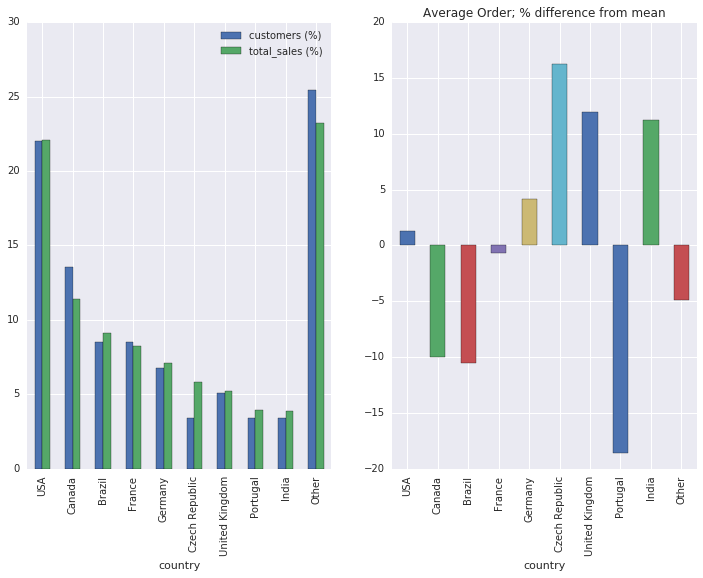

In [18]:
fig, axes = plt.subplots(1,2, figsize=(12,8))

sales_by_country[['customers (%)', 'total_sales (%)']].plot(kind = 'bar', ax = axes[0])
sales_by_country['order_diff_from_mean (%)'].plot(kind = 'bar', title = 'Average Order; % difference from mean', ax = axes[1])

plt.show()

From the table and figures above we can clearly see that most of the Chinook store customers and sales orginate from the US and Canada, with a large portion of profits originating from single customers in countries spread across the globe. In additon, it appears that there are a few customers in the Czech Republic that make large purchases (large % total sales relative to % customers).  

When asking how the average order in each country from the mean of global average orders; it is revealed that there are a few countries with orders that are over 10 % greater than global orders. Based on this data, there may be opportunities in these counties:
- Czech Republic
- Unitied Kingdom
- India

Note: The amount of data used in this analysis is minimal. As such colletcting more data regarding these customers in these countries could provide more confidence in these results and should be considered before allocating resources to these markets. 

## Summary & Additional Questions

Here we utilized a sample database to peform analyses regarding genre popularity, employee performance, and global sales using SQL and python. 


In addition to the business questions above, we could answer additional business questions such as
- Which artists are most popular?
- How many tracks have been purchased vs not purchased?
- What are the characteristics of unpurchased tracks? 
- Is the range of tracks in the store reflective of their sales popularity?
- Do protected vs non-protected media types have an effect on sales?

